The database is composed by several CSV (Comma-Separated Values) files, each one with 8 columns, one column for each sensor, according to:

column 1 tachometer signal that allows to estimate rotation frequency;

columns 2 to 4 underhang bearing accelerometer (axial, radiale tangential direction);

columns 5 to 7 overhang bearing accelerometer (axial, radiale tangential direction);

column 8 microphone.

source: https://www02.smt.ufrj.br/~offshore/mfs/page_01.html

According to the description of the columns there are not one two radial orthogonal accelerometers. Thus, it is not possible to observe the movement orbit of the rotating machine.

On the other hand, perhaps the tangential accelerometer is also moving radially, therefore orthogonal to the radial accelerometer.

Soft-DTW é uma função de perda diferenciável usada em análise de séries temporais, baseada no Dynamic Time Warping (DTW). Permite comparar séries de tamanhos variáveis, é robusta a deslocamentos e dilatações no tempo, e pode ser usada em aprendizado de máquina para tarefas como média, clustering e previsão.


- Instalação do soft-DTW:

1 - activate a venv
2 - pip install --upgrade pip setuptools wheel
3 - pip install numpy cython
4 - pip install soft-dtw

In [ ]:
# pip install soft-dtw

In [1]:
pip show soft-dtw

Name: soft-dtw
Version: 0.1.6
Summary: Python implementation of soft-DTW
Home-page: https://github.com/mblondel/soft-dtw/
Author: 
Author-email: 
License: Simplified BSD
Location: d:\IFSP\Matematica - Aulas\Codes\math\Lib\site-packages
Requires: chainer, cython, numpy, scikit-learn, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
# import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from tensorflow.keras import layers, models
# from tensorflow.keras.utils import plot_model
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#### 1 - df_desbalanceado_20g

In [3]:
# df_20g = "C:/Files/mafaulda_full/overhang/ball_fault/20g"
# df_normal = "C:/Files/mafaulda_full/normal"
df_unbalance_20g = "C:/Files/mafaulda_bas/imbal_small/20g"

#### 1.1 - Concatenação:

In [4]:
# Lista para armazenar os DataFrames

dataframes = []

# Verifica se o caminho fornecido é um diretório válido
if os.path.isdir(df_unbalance_20g):
    # Iterar pelos arquivos no diretório
    for filename in os.listdir(df_unbalance_20g):
        if filename.endswith(".csv"): 
            file_path = os.path.join(df_unbalance_20g, filename)
            
            try:
                # Lendo o arquivo CSV, pulando a primeira linha (cabeçalho).
                # O parâmetro skiprows=1 é a chave para resolver o problema do 'object' dtype.
                df = pd.read_csv(file_path, sep=',', header=None, skiprows=1)
                dataframes.append(df)
            except Exception as e:
                print(f"Não foi possível ler o arquivo {filename}: {e}")


    if dataframes:
        #Concatenando os dataframes em um único:
        df_unbalance_20g_concat = pd.concat(dataframes, ignore_index=True)

        # Mostrando as primeiras linhas e tipos de dados:
        print("__Dataframe combinado (df_20g_concat) ___")
        print(df_unbalance_20g_concat.head())
        print("\n--- Tipos de dados (dtypes) ---")
        print(df_unbalance_20g_concat.dtypes)
    else:
        print("Não houve leitura de arquivos")
else:
    print(f"diretório df_desbalanceado_20g não encontrado: {df_unbalance_20g}")


__Dataframe combinado (df_20g_concat) ___
         0         1         2       3
0 -0.53339  0.001064  0.000731 -2.6298
1 -0.52115 -0.004112 -0.002363 -2.6211
2 -0.52931  0.027923  0.026279 -2.5818
3 -0.53356  0.026850  0.030906 -2.6547
4 -0.51701  0.024686  0.024161 -2.5422

--- Tipos de dados (dtypes) ---
0    float64
1    float64
2    float64
3    float64
dtype: object


- Supondo ultima coluna como rotulos ou classes (y) e as demais como features (X):

In [5]:

X = df_unbalance_20g_concat.iloc[:, :].values         # Todas as colunas, menos a última
#y = df_unbalance_20g_concat.iloc[:, -1]         # Apenas a última coluna
y = np.full(X.shape[0], 1)  # Criando um array de rótulos com valor 1 para todas as amostras


In [7]:
print("--- Verificação de X e y ---")
# Para NumPy arrays, usamos fatiamento para ver o "cabeçalho" e .dtype para o tipo de dado
print("X head:\n", X[:4]) # Mostra as primeiras 5 linhas (fatiamento de array)
print("\nX numpy dtype:", X.dtype) # Mostra o tipo de dado do array NumPy
print("\ny head:\n", y[:4]) # Mostra as primeiras 5 linhas de y
print("\ny dtypes:", y.dtype) # Mostra o tipo de dado do array NumPy
print('--------------------------------------')
print("X shape:", X.shape)
print("y shape:", y.shape)
print('--------------------------------------')
print('ooooooooooooooooooooooooooooooooooooo')


--- Verificação de X e y ---
X head:
 [[-5.3339e-01  1.0645e-03  7.3059e-04 -2.6298e+00]
 [-5.2115e-01 -4.1120e-03 -2.3626e-03 -2.6211e+00]
 [-5.2931e-01  2.7923e-02  2.6279e-02 -2.5818e+00]
 [-5.3356e-01  2.6850e-02  3.0906e-02 -2.6547e+00]]

X numpy dtype: float64

y head:
 [1 1 1 1]

y dtypes: int64
--------------------------------------
X shape: (12249951, 4)
y shape: (12249951,)
--------------------------------------
ooooooooooooooooooooooooooooooooooooo


#### 1.2 - Normalização:

- É um comportamento esperado do pandas. Essa linha não se refere a uma coluna específica do seu DataFrame. Ela descreve o tipo de dados da própria lista de tipos que está sendo exibida. Como a lista contém vários objetos de tipo float64 e outros, o pandas a classifica como uma série de tipo object.
- fit (Ajustar/Aprender): A primeira parte, fit, "olha" para cada coluna (cada sensor), calcula a média (μ) e o desvio padrão (σ) daquela coluna específica, aprendendo os parâmetros de distribuição dos dados.

In [8]:
# Função para normalizar os dados. preprocess_data padroniza os dados antes de entregá-los ao modelo para tr

print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")

def preprocess_data(data_to_scale):                                  # X  é o conjunto de dados de entrada (as leituras dos 8 sensores de vibração
    print("   'X_scaled' foi criado com sucesso!")
    scaler = StandardScaler()
    scaled_data_out = scaler.fit_transform(data_to_scale)
        
    # VISUALIZAR OS DADOS NORMALIZADOS
    print("\n2. Gerando gráficos para visualização...")
    return scaled_data_out




1. Aplicando a normalização (StandardScaler) aos dados de X...


### 1.3 - Análise do sinal do tacômetro:


1. Aplicando a normalização (StandardScaler) aos dados de X...
   'X_scaled' foi criado com sucesso!

2. Gerando gráficos para visualização...
   'X_scaled' foi criado com sucesso!
   Formato do X_scaled: (12249951, 4), Tipo: <class 'numpy.ndarray'>
-----------------------------------------

2. Gerando gráficos para visualização...


C:\Users\carlo\AppData\Local\Temp\ipykernel_12864\3513223732.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
d:\IFSP\Matematica - Aulas\Codes\math\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


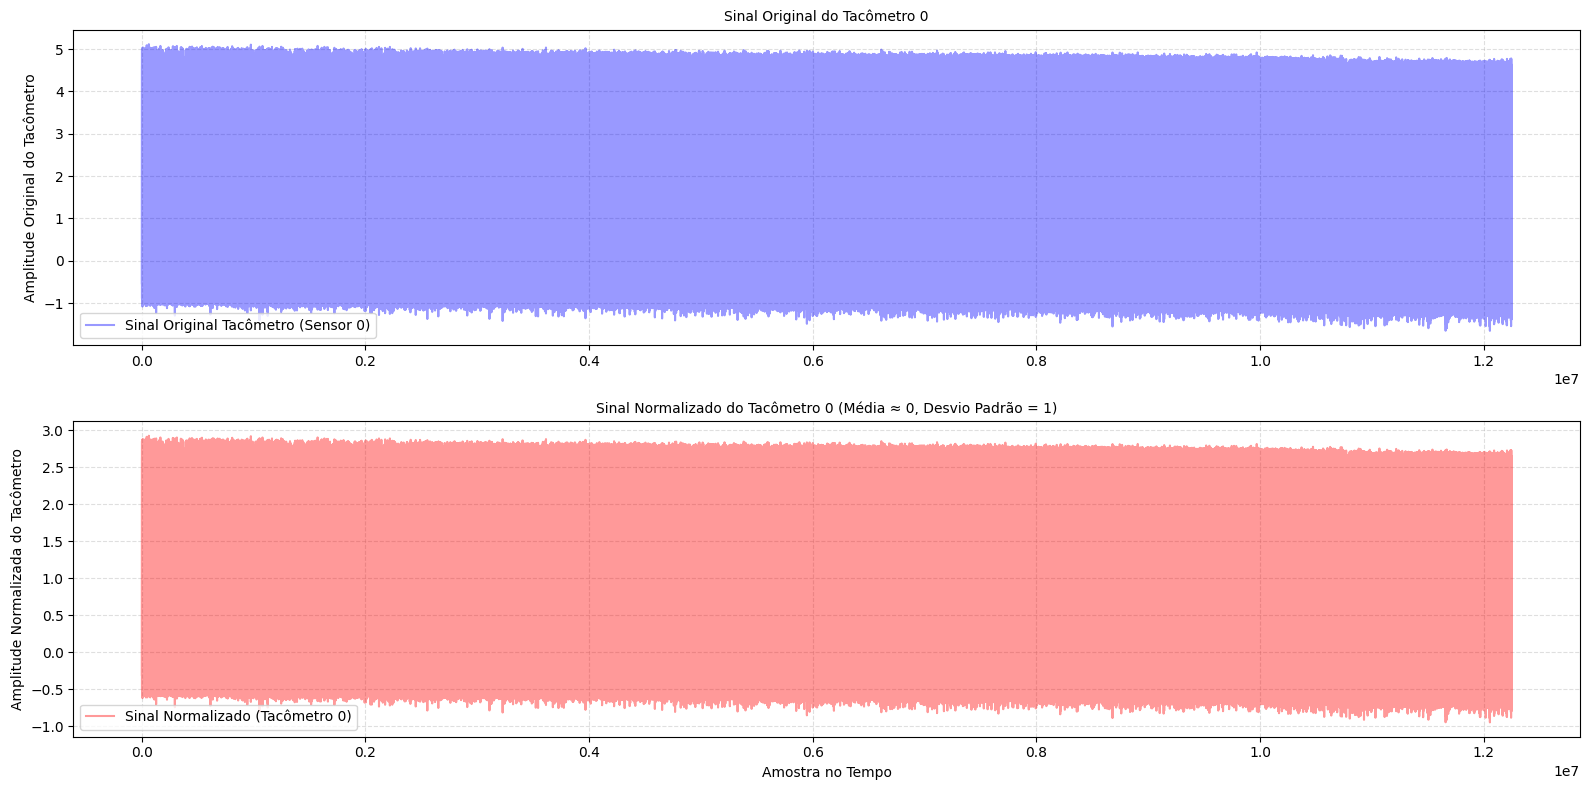

In [9]:
print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")
X_scaled = preprocess_data(X) # <--- CHAMA A FUNÇÃO E OBTÉM O RESULTADO
print("   'X_scaled' foi criado com sucesso!")
print(f"   Formato do X_scaled: {X_scaled.shape}, Tipo: {type(X_scaled)}")
print('-----------------------------------------')

# --- VISUALIZAR OS DADOS NORMALIZADOS (Plotagem) ---
print("\n2. Gerando gráficos para visualização...")

sensor_a_visualizar = 0 # Tacômetro (ou o índice da coluna do sensor que você quer plotar de X)

# Acessa os dados originais (X deve ser um array NumPy)
raw_tac_signal = X[:, sensor_a_visualizar]
# Acessa os dados já escalados
scaled_tac_signal = X_scaled[:, sensor_a_visualizar]

# --- Gráfico 1: Comparação do Sinal no Tempo ---
plt.figure(figsize=(16, 8))

# Gráfico do sinal original
plt.subplot(2, 1, 1)
plt.plot(raw_tac_signal, label=f'Sinal Original Tacômetro (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Tacômetro {sensor_a_visualizar}', fontsize=10)
plt.ylabel('Amplitude Original do Tacômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
plt.plot(scaled_tac_signal, label=f'Sinal Normalizado (Tacômetro {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Tacômetro {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel('Amostra no Tempo', fontsize=10)
plt.ylabel('Amplitude Normalizada do Tacômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

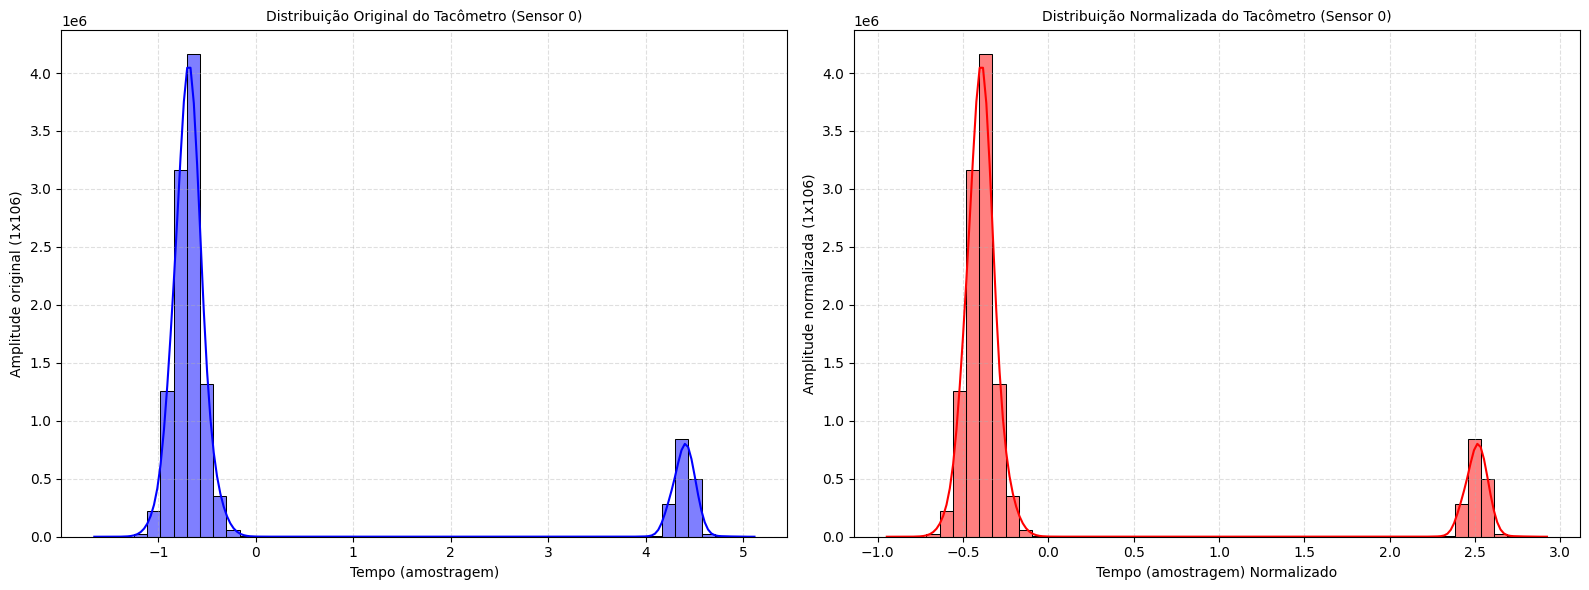


Visualização concluída.


In [11]:
# --- Gráfico 2: Comparação da Distribuição dos Dados (Histograma) ---
plt.figure(figsize=(16, 6))

# Histograma do sinal original
plt.subplot(1, 2, 1)
sns.histplot(raw_tac_signal, kde=True, color='blue', bins=50)
plt.title(f'Distribuição Original do Tacômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem)', fontsize=10)
plt.ylabel('Amplitude original (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

# Histograma do sinal normalizado
plt.subplot(1, 2, 2)
sns.histplot(scaled_tac_signal, kde=True, color='red', bins=50)
plt.title(f'Distribuição Normalizada do Tacômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem) Normalizado', fontsize=10)
plt.ylabel('Amplitude normalizada (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

print("\nVisualização concluída.")

#### - Analisando o sinal NÃO NORMALIZADO:


2. Gerando gráficos para visualização...


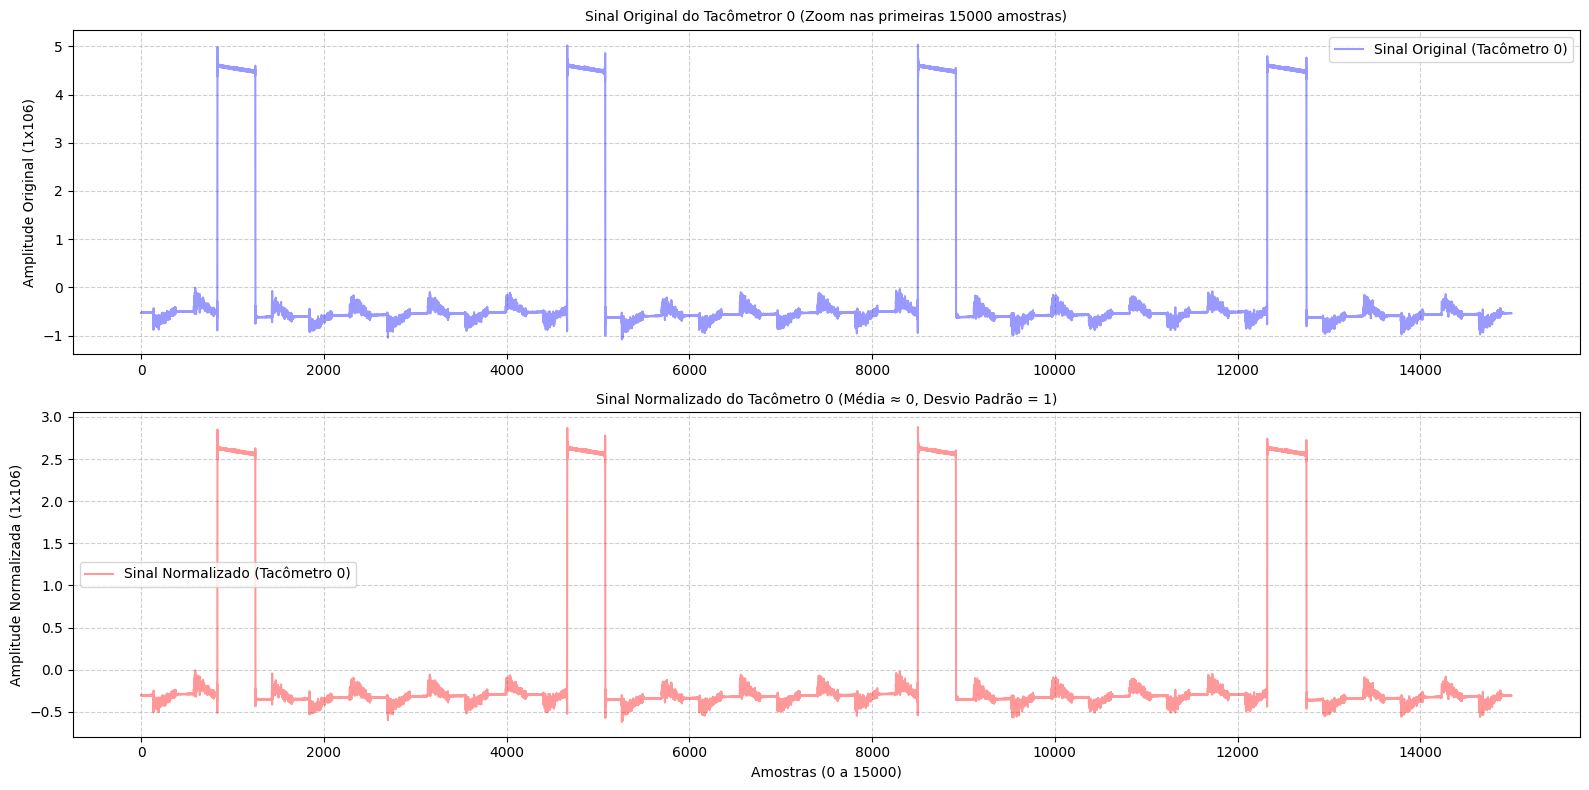

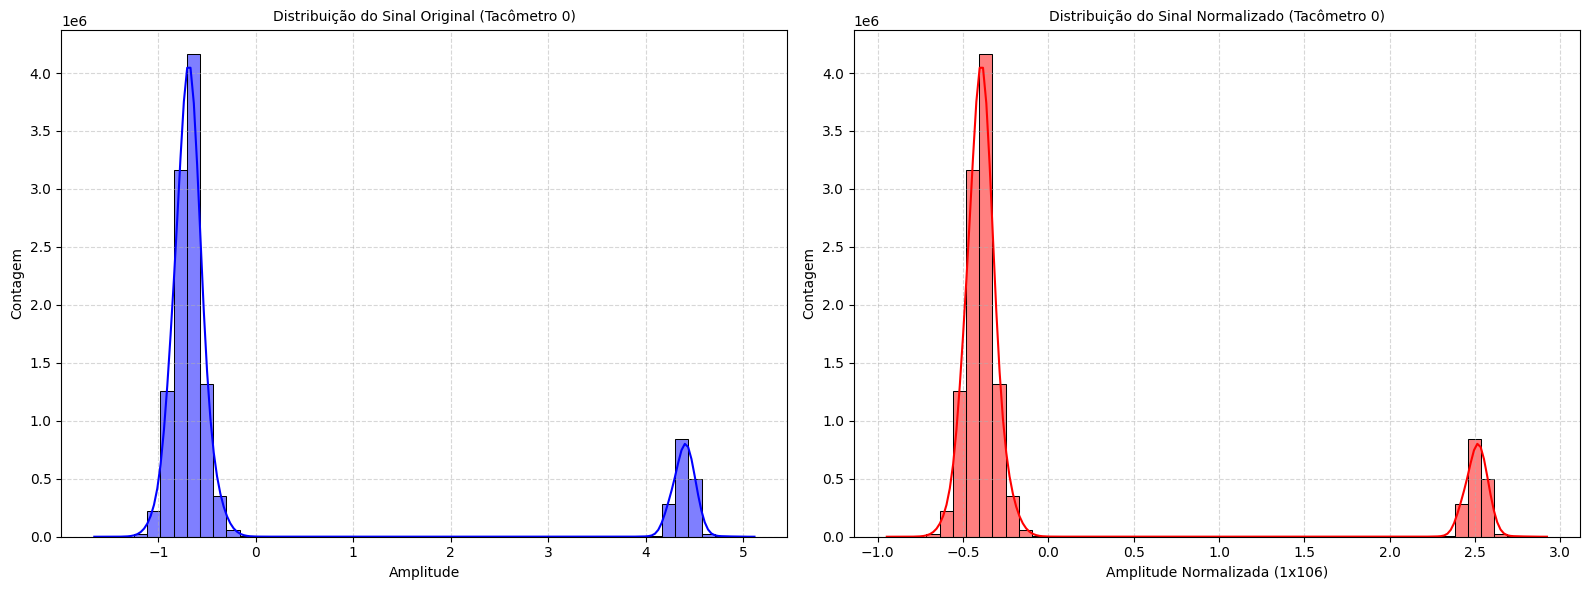


Visualização concluída.


In [12]:
# 2. VISUALIZAR OS DADOS NÃO NORMALIZADOS (COM ZOOM)
print("\n2. Gerando gráficos para visualização...")

# Escolha qual coluna do sensor (0 a 7) você quer visualizar
sensor_a_visualizar = 0 
# Define o número de amostras para o "zoom" para melhor visualização
num_amostras_plot = 15000

# Pega todos os dados da coluna do sensor escolhido. Removi o .values pois deve ser usado apenas para ler 
# os dados como um array NumPy, mas aqui estamos usando diretamente o DataFrame.
raw_tac_signal = X[:, sensor_a_visualizar]
#scaled_tac_signal = X_scaled[:, sensor_a_visualizar]

# --- Gráfico 1: Comparação do Sinal no Tempo do sinal original (com zoom) ---
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
# Plota apenas as primeiras 'num_amostras_plot' amostras para dilatar o eixo X
plt.plot(raw_tac_signal[:num_amostras_plot], label=f'Sinal Original (Tacômetro {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Tacômetror {sensor_a_visualizar} (Zoom nas primeiras {num_amostras_plot} amostras)', fontsize=10)
plt.ylabel('Amplitude Original (1x106)', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Gráfico do sinal não normalizado (zoom)
plt.subplot(2, 1, 2)
# Plota apenas as primeiras 'num_amostras_plot' amostras
plt.plot(scaled_tac_signal[:num_amostras_plot], label=f'Sinal Normalizado (Tacômetro {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Tacômetro {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel(f'Amostras (0 a {num_amostras_plot})', fontsize=10)
plt.ylabel('Amplitude Normalizada (1x106)', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- Gráfico 2: Comparação da Distribuição dos Dados (usando o sinal completo) ---
plt.figure(figsize=(16, 6))

# Histograma do sinal original
plt.subplot(1, 2, 1)
sns.histplot(raw_tac_signal, kde=True, color='blue', bins=50)
plt.title(f'Distribuição do Sinal Original (Tacômetro {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Amplitude', fontsize=10)
plt.ylabel('Contagem', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Histograma do sinal normalizado
plt.subplot(1, 2, 2)
sns.histplot(scaled_tac_signal, kde=True, color='red', bins=50)
plt.title(f'Distribuição do Sinal Normalizado (Tacômetro {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Amplitude Normalizada (1x106)', fontsize=10)
plt.ylabel('Contagem', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nVisualização concluída.")

- "Contagem" significa a frequência ou o número de vezes que um determinado valor de amplitude ocorreu no seu conjunto de dados.
- A linha azul contínua (chamada de KDE - Kernel Density Estimate) é uma versão suavizada do histograma. O pico dessa linha mostra qual é o valor de amplitude mais comum em todo o conjunto de dados.

- Análise no Domínio do Tempo (Sincronização e Visualização): Primeiro, vamos plotar o sinal de vibração do acelerômetro contra uma base de tempo real em segundos e, ao mesmo tempo, usar o tacômetro para calcular a rotação exata da máquina (RPM) naquele ensaio.
- Análise no Domínio da Frequência (objetivo): Em seguida, usaremos a Transformada Rápida de Fourier (FFT) para converter o sinal de vibração do domínio do tempo para o domínio da frequência. É aqui que a "assinatura" do desbalanceamento se tornará visível e quantificável.
- o sinal do tacômetro nos dá a base de tempo (a rotação da máquina), e o sinal do acelerômetro nos dá a vibração.
- A categoria imbalance 20g já foi carregada.

In [37]:
COLUNA_TACOMETRO = 0
# Coluna do acelerômetro radial do overhang (sexta coluna, índice 5)
COLUNA_ACELEROMETRO = 5 

# Parâmetros do dataset MAFAULDA
TAXA_AMOSTRAGEM = 50000  # 50 kHz
DURACAO_ENSAIO_S = 5    # 5 segundos

In [34]:


# --- FUNÇÃO PARA ANÁLISE E PLOTAGEM ---
# --- FUNÇÃO PARA ANÁLISE E PLOTAGEM ---
def analisar_sinal_temporal(caminho_arquivo, nome_condicao):
    """
    Carrega, analisa e plota o sinal de vibração e calcula o RPM a partir do tacômetro.
    """
    if not os.path.exists(caminho_arquivo):
        print(f"AVISO: Arquivo não encontrado: {caminho_arquivo}")
        return None, None

    print(f"\n--- Analisando Condição: {nome_condicao} ---")
    
    # Carrega o arquivo CSV, pulando a linha de cabeçalho se houver
    df = pd.read_csv(caminho_arquivo, header=None, skiprows=1)

    # Extrai os sinais do acelerômetro e do tacômetro
    sinal_acelerometro = df.values
    sinal_tacometro = df.values


In [13]:
if 'sinal_tacometro' not in locals():
    print("AVISO: 'sinal_tacometro' não definido. Criando sinal de tacômetro de exemplo para demonstração.")
    TAXA_AMOSTRAGEM = 50000
    DURACAO_ENSAIO_S = 5
    t = np.linspace(0, DURACAO_ENSAIO_S, DURACAO_ENSAIO_S * TAXA_AMOSTRAGEM, endpoint=False)
    # Sinal simulado de tacômetro: pulsos a 20 Hz (1200 RPM)
    sinal_tacometro = ((np.sin(2 * np.pi * 20 * t) > 0.5) * 5).astype(np.float32) + np.random.randn(len(t)) * 0.1
    COLUNA_TACOMETRO = 0 # Define para fins de impressão, não para extração real

print("\n--- Cálculo do RPM a partir do Tacômetro ---")
print("O tacômetro gera um pulso por rotação. Contamos os pulsos.")
print("Um pulso é detectado quando o sinal cruza um limiar (ex: valor 2.5) para cima.")

limiar_pulso = 2.5 # Garante que o limiar está definido

pulsos = np.where((sinal_tacometro[:-1] < limiar_pulso) & (sinal_tacometro[1:] >= limiar_pulso))[0] # Adicionado [0] para obter apenas os índices
num_pulsos = len(pulsos)
    
# Calcula RPM (Rotações por Minuto)
if DURACAO_ENSAIO_S > 0: # Adicionado verificação para evitar divisão por zero
    rpm = (num_pulsos / DURACAO_ENSAIO_S) * 60
    print(f"RPM Calculado: {rpm:.2f}")
else:
    print("ERRO: DURACAO_ENSAIO_S deve ser maior que zero para calcular o RPM.")

AVISO: 'sinal_tacometro' não definido. Criando sinal de tacômetro de exemplo para demonstração.

--- Cálculo do RPM a partir do Tacômetro ---
O tacômetro gera um pulso por rotação. Contamos os pulsos.
Um pulso é detectado quando o sinal cruza um limiar (ex: valor 2.5) para cima.
RPM Calculado: 1200.00


In [ ]:

# --- Plotagem do Sinal de Vibração ---
    # Cria o eixo de tempo em segundos
num_amostras = len(sinal_acelerometro)
eixo_tempo_s = np.linspace(0, DURACAO_ENSAIO_S, num_amostras)
    
    # Zoom para visualizar melhor a forma de onda (primeiras 2000 amostras)
amostras_plot = 2000

plt.figure(figsize=(15, 5))
plt.plot(eixo_tempo_s[:amostras_plot], sinal_acelerometro[:amostras_plot], label=f'Sinal do Acelerômetro (Sensor {COLUNA_ACELEROMETRO})')
plt.title(f'Sinal de Vibração no Domínio do Tempo - Condição: {nome_condicao} (RPM: {rpm:.0f})', fontsize=14)
plt.xlabel('Tempo (segundos)', fontsize=12)
plt.ylabel('Amplitude da Vibração', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
    


# --- EXECUÇÃO ---
sinal_normal, rpm_normal = analisar_sinal_temporal(caminho_normal, "Normal")
sinal_desbalanceado, rpm_desbalanceado = analisar_sinal_temporal(caminho_desbalanceado, "Desbalanceamento 20g")

NameError: name 'sinal_acelerometro' is not defined